# Churn Prediction

## Case 1 - Bank Churn

let's work with kaggle dataset https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers - Bank 

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### distribution of classes

In [3]:
df['Exited'].value_counts()  # target

0    7963
1    2037
Name: Exited, dtype: int64

### train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

### classes for our pipeline

In [5]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

### lists of features

In [6]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### demonstration of work of FeatureSelector

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
                ('selector', FeatureSelector(column='Gender')),
                ('ohe', OHEEncoder(key='Gender'))
            ])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


### creation of transformers for each feature

In [8]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [9]:
final_transformers[2]

('Tenure',
 Pipeline(steps=[('selector', FeatureSelector(column='Tenure')),
                 ('ohe', OHEEncoder(key='Tenure'))]))

### let's unite it all in one pipeline and add a model

In [10]:
from sklearn.ensemble import RandomForestClassifier

feats = FeatureUnion(final_transformers)

pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

### let's teach/fit our model

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [12]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [13]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, \
                            classification_report, precision_recall_curve, confusion_matrix

In [14]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


### let's draw confusion matrix

In [15]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


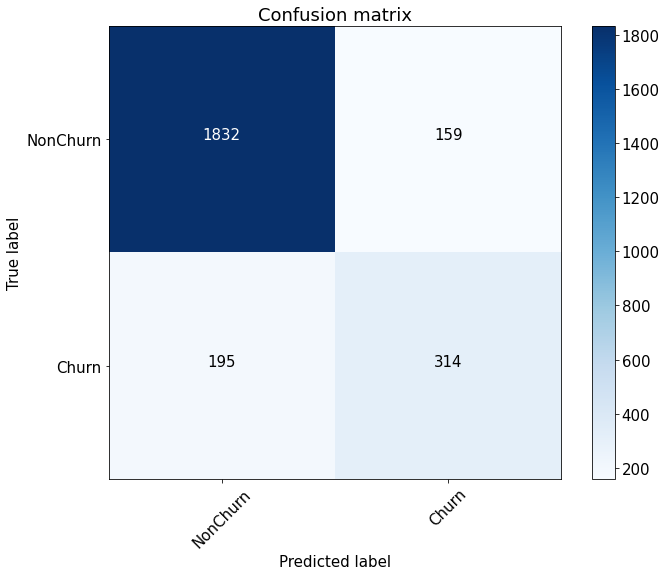

In [16]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

### searching best params with GridSearchCV

In [17]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [18]:
grid = GridSearchCV(pipeline,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

{'classifier__max_depth': None,
 'classifier__max_features': 0.5,
 'classifier__min_samples_leaf': 3}

In [19]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, 
                                          max_features=0.5, 
                                          min_samples_leaf=3, 
                                          random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

### let's draw the confusion matrix again and check the changes in metrics

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


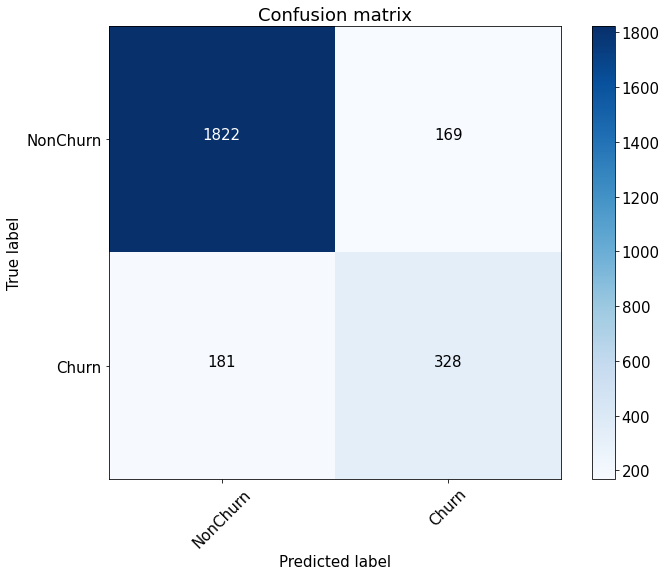

In [20]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

our metrics have improved

## Case 2 - Online Game Churn

https://mlbootcamp.ru/ru/round/10/sandbox/

В этой задаче необходимо научиться предсказывать, остается ли участник в он-лайн игре или уходит из нее. Уходом считается отсутствие его в игре в течение недели.

 

Всего используется 12 признаков, вычисленных за 2 предыдущие недели:

- maxPlayerLevel - максимальный уровень игры, который прошел игрок
- numberOfAttemptedLevels - количество уровней, которые попытался пройти игрок
- attemptsOnTheHighestLevel - число попыток, сделанных на самом высоком уровне
- totalNumOfAttempts - общее число попыток
- averageNumOfTurnsPerCompletedLevel - среднее количество ходов, выполненных на успешно пройденных уровнях
- doReturnOnLowerLevels - делал ли игрок возвраты к игре на уже пройденных уровнях
- numberOfBoostersUsed - количество использованных бустеров
- fractionOfUsefullBoosters - количество бустеров, использованных во время успешных попыток (игрок прошел уровнь)
- totalScore - общее количество набранных очков
- totalBonusScore - общее количество набранных бонусных очков
- totalStarsCount - общее количество набранных звезд
- numberOfDaysActuallyPlayed - количество дней, когда пользователь играл в игру

Все предоставленные для задачи данные разбиты на две части: обучающую (x_train.csv и y_train.csv) и тестовую (x_test.csv). Каждая строка файлов x_train.csv и x_test.csv соответствует одному пользователю. Данные в строке разделены точкой с запятой. Первая строка содержит имена признаков. Файл y_train.csv содержит значения 1 или 0 в зависимости от того, остался пользователь в игре или вышел из нее соответственно.

Как обучающая (x_train.csv и y_train.csv), так и тестовая (x_test.csv) выборки содержат информацию о 25289 пользователях.

Решение победителя https://habr.com/ru/post/324916/ (немного адаптированное)

In [21]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingClassifier

from datetime import datetime as dt

import random
random.seed(666)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [22]:
def loss_func(y_true, y_pred):
    return log_loss(y_true, y_pred)


all_train = pd.read_csv('x_train.csv', sep=';')
all_target = pd.read_csv('y_train.csv', sep=';', names=['TARGET'])
all_train['TARGET'] = all_target['TARGET']

### train test split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(all_train, all_train['TARGET'], random_state=0)

In [24]:
cols_to_drop = ['ID', 'TARGET']
cols = list(set(all_train.columns) - set(cols_to_drop))
base_cols = cols

### identification of same rows

In [25]:
X_train['row_id'] = X_train[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)
X_test['row_id'] = X_test[base_cols].apply(lambda row: '_'.join([str(i) for i in row]), axis=1)

gb = X_train.groupby(['row_id'], as_index=False).size()
gb.name = 'size'
gb = gb.reset_index()
sizdata = gb[gb['size'] > 50].sort_values('size', ascending=False)

similar_data = X_train[X_train['row_id'].isin(sizdata['row_id'].values)]

### creation of feature interractions

In [26]:
def transform_data(data):
    for i1, col1 in enumerate(base_cols):
        data[col1 + '_log'] = np.log(data[col1] + 1.1)

        for i2, col2 in enumerate(base_cols):
            data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
            data['%s_%s_2' % (col1, col2)] = data[col1] + data[col2]
            data['%s_%s_3' % (col1, col2)] = data[col1] / (data[col2] + 0.1)
            data['%s_%s_4' % (col1, col2)] = data[col1] * data[col2]

            data['%s_%s_11' % (col1, col2)] = data[col1] - np.log(data[col2] + 1)
            data['%s_%s_22' % (col1, col2)] = data[col1] + np.log(data[col2] + 1)
            data['%s_%s_33' % (col1, col2)] = data[col1] / (np.log(data[col2] + 1) + 0.1)
            data['%s_%s_44' % (col1, col2)] = data[col1] * np.log(data[col2] + 1)

    return data


X_train_tr = transform_data(X_train)
X_test_tr = transform_data(X_test)

C:\Users\fross\AppData\Local\Temp/ipykernel_2952/1254723530.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data[col1 + '_log'] = np.log(data[col1] + 1.1)
C:\Users\fross\AppData\Local\Temp/ipykernel_2952/1254723530.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['%s_%s_1' % (col1, col2)] = data[col1] - data[col2]
C:\Users\fross\AppData\Local\Temp/ipykernel_2952/1254723530.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

In [27]:
cols = [col for col in X_train_tr.drop(['TARGET', 'row_id'], 1).columns]

C:\Users\fross\AppData\Local\Temp/ipykernel_2952/598487177.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  cols = [col for col in X_train_tr.drop(['TARGET', 'row_id'], 1).columns]


In [28]:
len(cols)

1176

### data scaling

In [29]:
X_train_gb = X_train[cols].values

scaler_reg = MinMaxScaler((-1, 1))
scaler_reg.fit(np.vstack((X_train_tr[cols], X_test_tr[cols])))
X_train_reg = scaler_reg.transform(X_train_tr[cols])
X_test_reg = scaler_reg.transform(X_test_tr[cols])

C:\Users\fross\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(
C:\Users\fross\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


### fitting/teaching different models

In [30]:
params = {
    'silent': 1,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'eta': 0.01,
    'subsample': 0.4,
    'min_child_weight': 7,
    'n': 580,
    'verbose': 1
}

dtrain = xgb.DMatrix(X_train_tr[cols], label=y_train, missing=np.NaN)

bst1 = xgb.XGBClassifier(boosting_type='gbdt', **params)
bst1.fit(X_train_tr[cols], y_train)

[11:32:39] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "boosting_type", "n", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              callbacks=None, colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, early_stopping_rounds=None,
              enable_categorical=False, eta=0.01, eval_metric=None, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.00999999978,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=4,
              max_leaves=0, min_child_weight=7, missing=nan,
              monotone_constraints='()', n=580, n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', ...)

In [31]:
params_est = {
    'n_estimators': 300,
    'loss': 'exponential',
    'learning_rate': 0.08,
    'subsample': 0.6910000000000001,
    'min_samples_leaf': 340,
    'max_features': 53,
    'random_state': 1,
    'verbose': 1
}

bst2 = GradientBoostingClassifier(**params_est)
bst2.fit(X_train_tr[cols], y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.8750           0.0308           33.34s
         2           0.8494           0.0265           32.36s
         3           0.8231           0.0237           30.58s
         4           0.8008           0.0213           29.58s
         5           0.7865           0.0191           28.95s
         6           0.7717           0.0167           28.34s
         7           0.7524           0.0150           28.10s
         8           0.7394           0.0136           27.81s
         9           0.7250           0.0113           27.61s
        10           0.7164           0.0100           27.36s
        20           0.6568           0.0026           25.76s
        30           0.6410           0.0006           24.01s
        40           0.6405           0.0001           22.84s
        50           0.6334           0.0000           21.68s
        60           0.6316           0.0000           20.79s
       

GradientBoostingClassifier(learning_rate=0.08, loss='exponential',
                           max_features=53, min_samples_leaf=340,
                           n_estimators=300, random_state=1,
                           subsample=0.6910000000000001, verbose=1)

In [32]:
bst3 = LogisticRegression()
bst3.fit(X_train_reg, y_train)

C:\Users\fross\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

### calculation of scores

In [33]:
t1 = bst1.predict_proba(X_test_tr[cols])[:, 1]
t2 = bst2.predict_proba(X_test_tr[cols].values)[:, 1]
t3 = bst3.predict_proba(X_test_reg)[:, 1]

C:\Users\fross\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


### table of results

In [34]:
results = pd.DataFrame({'y_true': y_test,
              'XGB': t1,
              'GBM': t2,
              'LR': t3})
results['AVG_xgb_gbm_lr'] = results[['XGB', 'GBM', 'LR']].mean(axis=1)
results['AVG_xgb_lr'] = results[['XGB', 'LR']].mean(axis=1)
results

,y_true,XGB,GBM,LR,AVG_xgb_gbm_lr,AVG_xgb_lr
8424,1,0.617776,0.664565,0.664379,0.648907,0.641078
6504,0,0.201585,0.021804,0.026127,0.083172,0.113856
11281,0,0.358372,0.234983,0.193677,0.262344,0.276025
15938,1,0.744776,0.937638,0.943917,0.875443,0.844346
9213,0,0.334518,0.261851,0.241806,0.279392,0.288162
...,...,...,...,...,...,...
7817,0,0.317555,0.174169,0.235451,0.242392,0.276503
23443,0,0.614048,0.589854,0.656693,0.620198,0.635371
9533,0,0.219870,0.024797,0.076783,0.107150,0.148327
24432,1,0.596146,0.582806,0.649345,0.609432,0.622746


### metrics calculation

In [35]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f, Roc-AUC=%.3f' % (thresholds[ix], 
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix],
                                                                            roc_auc_score(y_test, probs)))
    return thresholds[ix]

In [36]:
xgb_th = get_metrics(results['XGB'])
gbm_th = get_metrics(results['GBM'])
lr_th = get_metrics(results['LR'])
blending_th = get_metrics(results['AVG_xgb_gbm_lr'])
blending2_th = get_metrics(results['AVG_xgb_lr'])

Best Threshold=0.429735, F-Score=0.717, Precision=0.671, Recall=0.769, Roc-AUC=0.881
Best Threshold=0.350601, F-Score=0.710, Precision=0.653, Recall=0.779, Roc-AUC=0.879
Best Threshold=0.386866, F-Score=0.714, Precision=0.668, Recall=0.767, Roc-AUC=0.880
Best Threshold=0.431233, F-Score=0.712, Precision=0.690, Recall=0.736, Roc-AUC=0.881
Best Threshold=0.406127, F-Score=0.714, Precision=0.667, Recall=0.769, Roc-AUC=0.881


# Client LifeTime Value

all csv files are from here - https://www.kaggle.com/olistbr/brazilian-ecommerce

In [37]:
# !pip install lifetimes

In [38]:
import pandas as pd
import numpy as np

import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from lifetimes.utils import *
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_period_transactions, \
                               plot_cumulative_transactions, plot_incremental_transactions
from lifetimes.generate_data import beta_geometric_nbd_model
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions, plot_history_alive

In [39]:
orders = pd.read_csv('olist_orders_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
cust = pd.read_csv('olist_customers_dataset.csv')

In [40]:
orders.head(1)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00


In [41]:
items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


In [42]:
cust.head(1)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP


In [43]:
print(cust.columns)

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')


### 'customer_unique_id' is a unique identifier of a client; let's take a look on the distribution of number of purchases per a client

In [44]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
dtype: int64

In [45]:
orders = pd.merge(orders, cust[['customer_id', 'customer_unique_id']], on='customer_id')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,7c142cf63193a1473d2e66489a9ae977
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,72632f0f9dd73dfee390c9b22eb56dd6


### in 'price' there's the total price of an order, not a price of a separate item; let's keep only the first item of each order and drop the rest

In [46]:
print(items.columns)
items.drop_duplicates('order_id', keep='first', inplace=True)

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')


In [47]:
items.head(1)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29


### let's add info about price

In [48]:
transaction_data = pd.merge(orders, items, 'inner', 'order_id')
transaction_data = transaction_data[['customer_unique_id', 'order_purchase_timestamp', 'price']]

transaction_data['date'] = pd.to_datetime(transaction_data['order_purchase_timestamp']).dt.date
transaction_data = transaction_data.drop('order_purchase_timestamp', axis=1)
transaction_data.head(2)

,customer_unique_id,price,date
0,7c396fd4830fd04220f754e42b4e5bff,29.99,2017-10-02
1,af07308b275d755c9edb36a90c618231,118.70,2018-07-24


### transformation of transaction_data into RFM DataFrame with summary_data_from_transaction_data (a lifetimes function)

- recency - time between the first and the last purchase
- frequency - number of purchases
- monetary_value - mean price of all purchases of a customer

In [49]:
summary = summary_data_from_transaction_data(
    transaction_data, 'customer_unique_id', 'date',
    monetary_value_col='price',
    # include_first_transaction=True
)
summary.head(2)

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0


In [50]:
summary.describe()

,frequency,recency,T,monetary_value
count,95420.000000,95420.000000,95420.000000,95420.000000
mean,0.024198,2.683389,246.184846,2.474897
std,0.178936,25.263074,153.656402,26.579606
min,0.000000,0.000000,5.000000,0.000000
25%,0.000000,0.000000,122.000000,0.000000
50%,0.000000,0.000000,227.000000,0.000000
75%,0.000000,0.000000,356.000000,0.000000
max,15.000000,633.000000,729.000000,1999.990000


In [51]:
print(summary.shape)
summary.head()

(95420, 4)


,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,116.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,119.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,542.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,326.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,293.0,0.0


Преобразовали транзакции клиентов в агрегированную таблицу. У многих клиентов частота, давность и денежная масса = 0, например, customer 0000366f3b9a7992bf8c76cfdf3221e2 ( Lifetimes учитывает только тех клиентов, которые совершили повторные покупки).

Используя дни как периоды времени (также могут быть определены как недели или месяцы), переменные определяются следующим образом для модели Lifetimes:

- frequency: количество повторных покупок, сделанных покупателем.
- T: возраст клиента в днях.
- recency: возраст покупателя в днях на момент последней покупки.
- monetary_value: среднее значение покупок клиента, исключая 1-ю покупку.


частота исключает первую покупку покупателя, потому что это считается днем ​​рождения покупателя. После этого вы можете начать сомневаться, жив ли этот покупатель.

In [52]:
summary[summary['frequency'] > 2].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
083ca1aa470c280236380973a48f77c6,3.0,381.0,402.0,66.326667
12d8b5ed661190a3a08183644dfc504d,3.0,402.0,526.0,146.566667
1b6c7548a2a1f9037c1fd3ddfed95f33,6.0,93.0,294.0,97.831667
2ddc001b620bd90d0f4378cfde1db887,3.0,186.0,338.0,117.116667
35ecdf6858edc6427223b64804cf028e,3.0,238.0,394.0,81.630000


In [53]:
transaction_data[transaction_data['customer_unique_id'] == '083ca1aa470c280236380973a48f77c6']

,customer_unique_id,price,date
30398,083ca1aa470c280236380973a48f77c6,56.99,2017-08-05
32832,083ca1aa470c280236380973a48f77c6,19.90,2017-07-28
46124,083ca1aa470c280236380973a48f77c6,82.00,2018-08-13
81115,083ca1aa470c280236380973a48f77c6,59.99,2017-08-16


клиент 004288347e5e88a27ded2bb23747066c сделал две покупки с Olist, но его частота равна 1, а значение monetary_value равно 87,90 долларов США в зависимости от того, как определены частота и monetary_value

In [54]:
summary['frequency'].value_counts()

0.0     93335
1.0      1927
2.0       126
3.0        18
4.0         6
5.0         5
6.0         2
15.0        1
Name: frequency, dtype: int64

Наблюдаемые частоты - экспоненциальное распределение

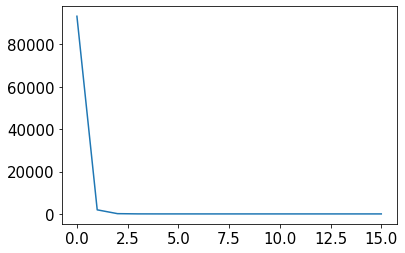

In [55]:
summary['frequency'].value_counts().plot()
plt.show()

In [56]:
bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 95420 subjects, a: 2.07, alpha: 65.86, b: 0.35, r: 0.02>

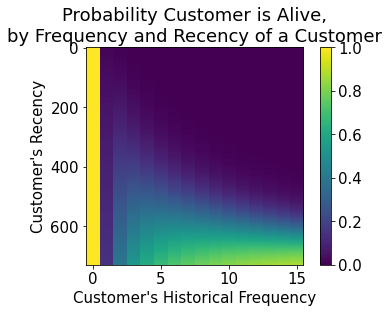

In [57]:
plot_probability_alive_matrix(bgf);

C:\Users\fross\anaconda3\lib\site-packages\lifetimes\generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


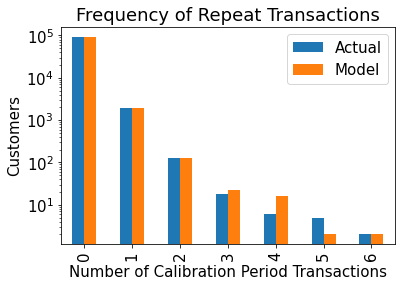

In [58]:
plot_period_transactions(bgf).set_yscale('log');

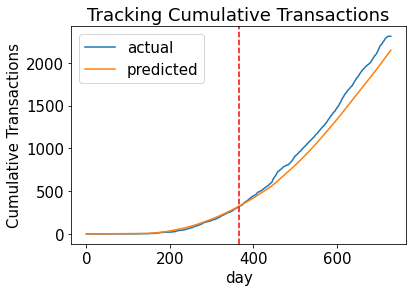

In [59]:
summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'customer_unique_id', 'date',
                                                    calibration_period_end='2017-09-03',
                                                    observation_period_end='2018-09-03' )

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_cumulative_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);

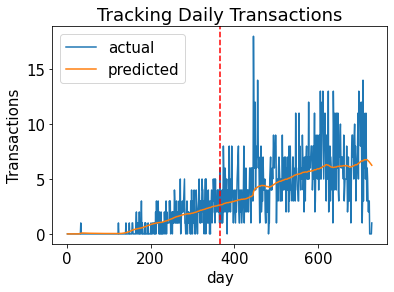

In [60]:
plot_incremental_transactions(bgf, transaction_data, 'date', 'customer_unique_id', 730, 365);

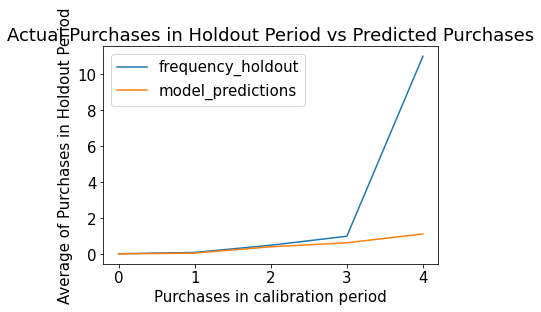

In [61]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout);

In [62]:
cust.groupby('customer_unique_id').size().value_counts()

1     93099
2      2745
3       203
4        30
5         8
6         6
7         3
9         1
17        1
dtype: int64

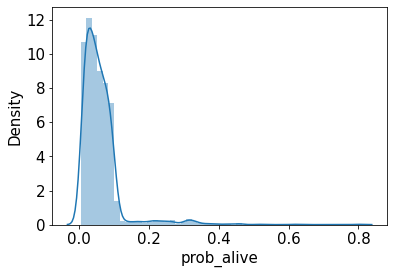

In [63]:
df = summary[summary['frequency'] > 0]
df['prob_alive'] = bgf.conditional_probability_alive(df['frequency'], df['recency'], df['T'])
sns.distplot(df['prob_alive']);

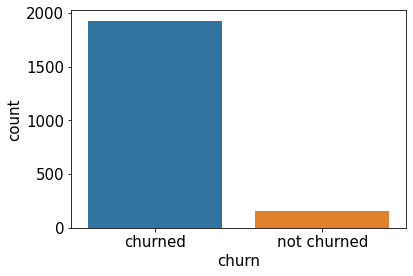

In [64]:
df['churn'] = ['churned' if p < .1 else 'not churned' for p in df['prob_alive']]
sns.countplot(df['churn']);

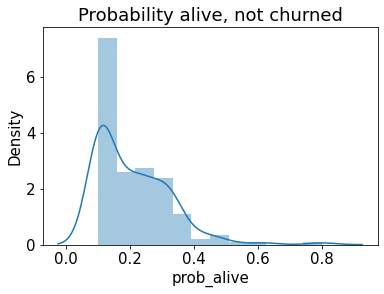

In [65]:
sns.distplot(df[df['churn'] == 'not churned']['prob_alive']).set_title('Probability alive, not churned');

In [66]:
df['churn'][(df['prob_alive'] >= .1) & (df['prob_alive'] < .2)] = "high risk"
df['churn'].value_counts()

churned        1928
high risk        84
not churned      73
Name: churn, dtype: int64

In [67]:
transaction_data.date = pd.to_datetime(transaction_data.date).dt.date  

In [68]:
summary[summary['frequency'] > 3].head()

,frequency,recency,T,monetary_value
customer_unique_id,,,,
1b6c7548a2a1f9037c1fd3ddfed95f33,6.0,93.0,294.0,97.831667
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,255.0,106.150000
3e43e6105506432c953e165fb2acf44c,5.0,162.0,350.0,156.650000
47c1a3033b8b77b3ab6e109eb4d5fdf3,4.0,170.0,392.0,172.200000
4e65032f1f574189fb793bac5a867bbc,4.0,445.0,526.0,94.795000


Список актов покупки с суммой
                     customer_unique_id  price        date
21870  47c1a3033b8b77b3ab6e109eb4d5fdf3   38.0  2017-08-07
57015  47c1a3033b8b77b3ab6e109eb4d5fdf3   59.9  2017-08-07
21849  47c1a3033b8b77b3ab6e109eb4d5fdf3   58.9  2017-08-22
40097  47c1a3033b8b77b3ab6e109eb4d5fdf3  378.0  2017-09-27
79880  47c1a3033b8b77b3ab6e109eb4d5fdf3  199.9  2017-11-27
16372  47c1a3033b8b77b3ab6e109eb4d5fdf3   52.0  2018-01-24


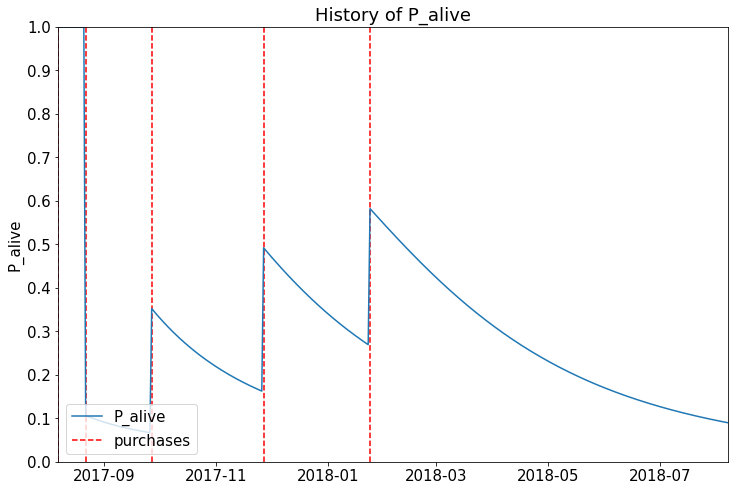

In [69]:
from lifetimes.plotting import plot_history_alive

fig = plt.figure(figsize=(12,8))
id = '47c1a3033b8b77b3ab6e109eb4d5fdf3'
days_since_birth = 365
sp_trans = transaction_data.loc[transaction_data.customer_unique_id==id,:]
print('Список актов покупки с суммой')
print(sp_trans.sort_values('date'))
plot_history_alive(bgf, days_since_birth, sp_trans, 'date')
plt.show()